/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.Dat

/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.Dat

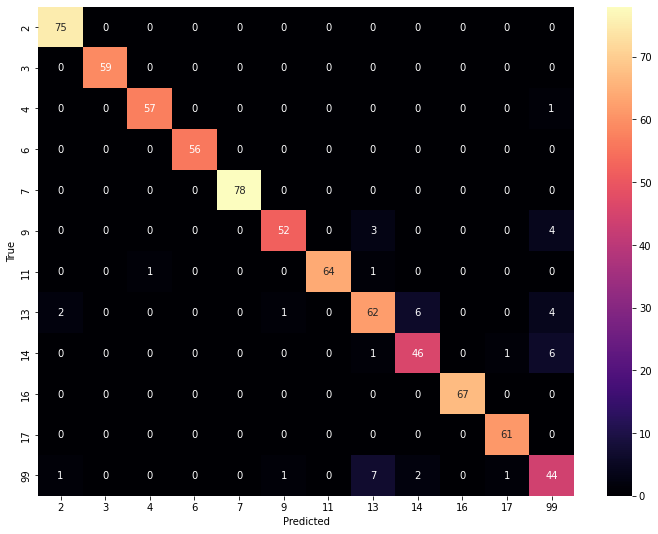

Stacking Classifier Accuracy: 0.943717277486911

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        75
           1       1.00      1.00      1.00        59
           2       0.98      0.98      0.98        58
           3       1.00      1.00      1.00        56
           4       1.00      1.00      1.00        78
           5       0.96      0.88      0.92        59
           6       1.00      0.97      0.98        66
           7       0.84      0.83      0.83        75
           8       0.85      0.85      0.85        54
           9       1.00      1.00      1.00        67
          10       0.97      1.00      0.98        61
          11       0.75      0.79      0.77        56

    accuracy                           0.94       764
   macro avg       0.94      0.94      0.94       764
weighted avg       0.94      0.94      0.94       764



In [2]:
# Import necessary libraries
import json
import ast
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# Data preprocessing function
def preprocess_data(df):
    """
    Preprocesses a DataFrame by applying transformations to specific columns.
    - Converts stringified sequences into Python lists of integers or floats.
    - Converts approximate latitude and longitude values into integers.
    - Converts boolean sequences into binary values (0 or 1).
    - Drops unnecessary columns after processing.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be processed.

    Returns:
    pd.DataFrame: The processed DataFrame with transformed columns.
    """
    # Convert stringified sequences to lists of integers or floats using eval
    df["vehicles_sequence"] = df["vehicles_sequence"].apply(eval)
    df["events_sequence"] = df["events_sequence"].apply(eval)
    df["seconds_to_incident_sequence"] = df["seconds_to_incident_sequence"].apply(eval)
    df["train_kph_sequence"] = df["train_kph_sequence"].apply(eval)

    # Convert approx_lat and approx_lon to integers (handling potential NaN values)
    df["approx_lat"] = (
        pd.to_numeric(df["approx_lat"], errors="coerce").fillna(np.nan).astype(int)
    )
    df["approx_lon"] = (
        pd.to_numeric(df["approx_lon"], errors="coerce").fillna(np.nan).astype(int)
    )

    # Convert boolean sequences (represented as strings) into lists of 0s and 1s
    df["dj_ac_state_sequence"] = df["dj_ac_state_sequence"].apply(
        lambda x: [1 if val else 0 for val in eval(x)]
    )
    df["dj_dc_state_sequence"] = df["dj_dc_state_sequence"].apply(
        lambda x: [1 if val else 0 for val in eval(x)]
    )

    # Drop the approx_lat and approx_lon columns after processing
    df.drop(columns=["approx_lat", "approx_lon"])

    return df


# Function to process the 'seconds_to_incident_sequence' column
def process_seconds_sequence(data):
    """
    Processes the 'seconds_to_incident_sequence' column in a DataFrame by extracting numerical
    sequences, calculating summary statistics, and performing time gap analysis.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the 'seconds_to_incident_sequence' column.

    Returns:
    pd.DataFrame: The updated DataFrame with additional columns for summary statistics
                  and time gap analysis.
    """
    # Convert the 'seconds_to_incident_sequence' column from string format to lists of floats
    seconds_sequence = (
        data["seconds_to_incident_sequence"]
        .astype(str)
        .apply(
            lambda x: [float(i) for i in x.replace("[", "").replace("]", "").split(",")]
        )
    )

    # Calculate summary statistics for the sequences
    data["seconds_mean"] = seconds_sequence.apply(np.mean)
    data["seconds_std"] = seconds_sequence.apply(np.std)
    data["seconds_max"] = seconds_sequence.apply(np.max)
    data["seconds_min"] = seconds_sequence.apply(np.min)
    data["seconds_sum"] = seconds_sequence.apply(np.sum)

    # Perform time gap analysis by calculating differences between consecutive elements
    data["seconds_gap_mean"] = seconds_sequence.apply(
        lambda x: np.mean(np.diff(x)) if len(x) > 1 else 0
    )
    data["seconds_gap_std"] = seconds_sequence.apply(
        lambda x: np.std(np.diff(x)) if len(x) > 1 else 0
    )

    return data


# Optuna-integrated function to process event sequences into TF-IDF features and merge with the original DataFrame
def process_event_sequences_to_tfidf_and_merge(
    df, column_name, max_df=0.9841170198383609, min_df=9
):
    """
    Transforms a specified column of event sequences into TF-IDF features and merges these features
    back into the original DataFrame. This function is intended for use with Optuna for hyperparameter optimization.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event sequences in the specified column.
    column_name (str): The name of the column to be processed (event sequences).
    max_df (float, optional): The maximum document frequency for the TF-IDF Vectorizer.
                              Terms appearing in more than this proportion of documents will be ignored.
                              Default is 0.9841170198383609.
    min_df (int, optional): The minimum document frequency for the TF-IDF Vectorizer.
                            Terms appearing in fewer than this number of documents will be ignored.
                            Default is 9.

    Returns:
    pd.DataFrame: The updated DataFrame with TF-IDF features merged into it.
    """
    # Convert the event sequences in the column to strings, where each sequence is joined by spaces
    docs = df[column_name].apply(lambda x: " ".join(str(w) for w in x))

    # Initialize the TF-IDF Vectorizer with specified max_df and min_df parameters
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)

    # Fit the vectorizer to the document strings and transform them into a sparse matrix
    tfidf = vectorizer.fit_transform(docs)

    # Convert the resulting sparse matrix into a DataFrame, preserving column names and index
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(
        tfidf, columns=vectorizer.get_feature_names_out(), index=df.index
    )

    # Merge the original DataFrame with the new TF-IDF DataFrame along the columns
    merged_df = pd.concat([df, tfidf_df], axis=1)

    return merged_df

# Feature engineering function
def feature_engineering(df):
    """
    Performs feature engineering on the input DataFrame by generating new features
    from existing columns related to vehicles, events, speed, and incident duration.
    Additional processing includes integrating statistical features and TF-IDF transformation.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing sequences and incident-related data.

    Returns:
    pd.DataFrame: The updated DataFrame with new engineered features and merged TF-IDF columns.
    """

    # Compute the total number of vehicles involved in each incident
    df["vehicle_count"] = df["vehicles_sequence"].apply(len)

    # Compute the number of unique vehicles involved in each incident
    df["vehicles_unique_count"] = df["vehicles_sequence"].apply(lambda x: len(set(x)))

    # Compute the total number of events associated with each incident
    df["event_count"] = df["events_sequence"].apply(len)

    # Compute the number of unique events associated with each incident
    df["events_unique_count"] = df["events_sequence"].apply(lambda x: len(set(x)))

    # Calculate the mean speed from the train's speed sequence
    df["mean_speed"] = df["train_kph_sequence"].apply(np.mean)

    # Calculate the total duration of the incident from the sequence of timestamps
    df["incident_duration"] = df["seconds_to_incident_sequence"].apply(
        lambda x: max(x) - min(x) if len(x) > 0 else 0
    )

    # Process the 'seconds_to_incident_sequence' column to extract statistical features
    df = process_seconds_sequence(df)

    # Calculate additional statistical features for the train's speed sequence
    df["max_speed"] = df["train_kph_sequence"].apply(np.max)
    df["min_speed"] = df["train_kph_sequence"].apply(np.min)
    df["std_speed"] = df["train_kph_sequence"].apply(np.std)

    # Calculate the average number of events per vehicle involved in the incident
    df["event_count_per_vehicle"] = df["event_count"] / df["vehicle_count"]

    # Calculate the average incident duration per vehicle involved
    df["incident_duration_per_vehicle"] = df["incident_duration"] / df["vehicle_count"]

    # Compute the difference between the maximum and minimum speed for incidents with multiple vehicles
    df["max_speed_diff"] = df.apply(
        lambda row: (
            np.max(row["train_kph_sequence"]) - np.min(row["train_kph_sequence"])
        )
        if len(row["vehicles_sequence"]) > 1
        else 0,
        axis=1,
    )

    # Apply TF-IDF processing to the 'events_sequence' column and merge the results with the DataFrame
    df = process_event_sequences_to_tfidf_and_merge(df, column_name="events_sequence")

    return df


def stacking_classification(X, y):
       # Apply SMOTE (Synthetic Minority Oversampling Technique) for class imbalance handling
     # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_res, y_res = smote.fit_resample(X, y_encoded)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42
    )
    
    # Base classifiers
    base_classifiers = [
        ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))),
        ('gb', make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100))),
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000)))
    ]
    
    # Meta-classifier
    meta_classifier = LogisticRegression()
    
    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_classifier,
        cv=5  # 5-fold cross-validation
    )
    
    # Fit and predict
    stacking_clf.fit(X_train, y_train)
    stacking_predictions = stacking_clf.predict(X_test)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, stacking_predictions)
    plt.figure(figsize=(12, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="magma",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return {
        'stacking_model': stacking_clf,
        'predictions': stacking_predictions,
        'accuracy': accuracy_score(y_test, stacking_predictions),
        'classification_report': classification_report(y_test, stacking_predictions)
    }

def main():
    # Main script execution
    file_path = "sncb_data_challenge.csv"  # Adjust this path as needed
    df = pd.read_csv(file_path, sep=";", index_col=0)

    # Preprocess data
    df = preprocess_data(df)

    # Perform feature engineering
    df = feature_engineering(df)

    # Train and evaluate models
    y = df["incident_type"]
    X = df.loc[:, "vehicle_count":]

     # Perform stacking classification
    results = stacking_classification(X, y)
        
    print("Stacking Classifier Accuracy:", results['accuracy'])
    print("\nClassification Report:\n", results['classification_report'])

if __name__ == "__main__":
    main()



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer


# Data preprocessing function
def preprocess_data(df):
    """
    Preprocesses a DataFrame by applying transformations to specific columns.
    - Converts stringified sequences into Python lists of integers or floats.
    - Converts approximate latitude and longitude values into integers.
    - Converts boolean sequences into binary values (0 or 1).
    - Drops unnecessary columns after processing.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be processed.

    Returns:
    pd.DataFrame: The processed DataFrame with transformed columns.
    """
    # Convert stringified sequences to lists of integers or floats using eval
    df["vehicles_sequence"] = df["vehicles_sequence"].apply(eval)
    df["events_sequence"] = df["events_sequence"].apply(eval)
    df["seconds_to_incident_sequence"] = df["seconds_to_incident_sequence"].apply(eval)
    df["train_kph_sequence"] = df["train_kph_sequence"].apply(eval)

    # Convert approx_lat and approx_lon to integers (handling potential NaN values)
    df["approx_lat"] = (
        pd.to_numeric(df["approx_lat"], errors="coerce").fillna(np.nan).astype(int)
    )
    df["approx_lon"] = (
        pd.to_numeric(df["approx_lon"], errors="coerce").fillna(np.nan).astype(int)
    )

    # Convert boolean sequences (represented as strings) into lists of 0s and 1s
    df["dj_ac_state_sequence"] = df["dj_ac_state_sequence"].apply(
        lambda x: [1 if val else 0 for val in eval(x)]
    )
    df["dj_dc_state_sequence"] = df["dj_dc_state_sequence"].apply(
        lambda x: [1 if val else 0 for val in eval(x)]
    )

    # Drop the approx_lat and approx_lon columns after processing
    df.drop(columns=["approx_lat", "approx_lon"])

    return df


# Function to process the 'seconds_to_incident_sequence' column
def process_seconds_sequence(data):
    """
    Processes the 'seconds_to_incident_sequence' column in a DataFrame by extracting numerical
    sequences, calculating summary statistics, and performing time gap analysis.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the 'seconds_to_incident_sequence' column.

    Returns:
    pd.DataFrame: The updated DataFrame with additional columns for summary statistics
                  and time gap analysis.
    """
    # Convert the 'seconds_to_incident_sequence' column from string format to lists of floats
    seconds_sequence = (
        data["seconds_to_incident_sequence"]
        .astype(str)
        .apply(
            lambda x: [float(i) for i in x.replace("[", "").replace("]", "").split(",")]
        )
    )

    # Calculate summary statistics for the sequences
    data["seconds_mean"] = seconds_sequence.apply(np.mean)
    data["seconds_std"] = seconds_sequence.apply(np.std)
    data["seconds_max"] = seconds_sequence.apply(np.max)
    data["seconds_min"] = seconds_sequence.apply(np.min)
    data["seconds_sum"] = seconds_sequence.apply(np.sum)

    # Perform time gap analysis by calculating differences between consecutive elements
    data["seconds_gap_mean"] = seconds_sequence.apply(
        lambda x: np.mean(np.diff(x)) if len(x) > 1 else 0
    )
    data["seconds_gap_std"] = seconds_sequence.apply(
        lambda x: np.std(np.diff(x)) if len(x) > 1 else 0
    )

    return data


# Optuna-integrated function to process event sequences into TF-IDF features and merge with the original DataFrame
def process_event_sequences_to_tfidf_and_merge(
    df, column_name, max_df=0.9841170198383609, min_df=9
):
    """
    Transforms a specified column of event sequences into TF-IDF features and merges these features
    back into the original DataFrame. This function is intended for use with Optuna for hyperparameter optimization.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing event sequences in the specified column.
    column_name (str): The name of the column to be processed (event sequences).
    max_df (float, optional): The maximum document frequency for the TF-IDF Vectorizer.
                              Terms appearing in more than this proportion of documents will be ignored.
                              Default is 0.9841170198383609.
    min_df (int, optional): The minimum document frequency for the TF-IDF Vectorizer.
                            Terms appearing in fewer than this number of documents will be ignored.
                            Default is 9.

    Returns:
    pd.DataFrame: The updated DataFrame with TF-IDF features merged into it.
    """
    # Convert the event sequences in the column to strings, where each sequence is joined by spaces
    docs = df[column_name].apply(lambda x: " ".join(str(w) for w in x))

    # Initialize the TF-IDF Vectorizer with specified max_df and min_df parameters
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)

    # Fit the vectorizer to the document strings and transform them into a sparse matrix
    tfidf = vectorizer.fit_transform(docs)

    # Convert the resulting sparse matrix into a DataFrame, preserving column names and index
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(
        tfidf, columns=vectorizer.get_feature_names_out(), index=df.index
    )

    # Merge the original DataFrame with the new TF-IDF DataFrame along the columns
    merged_df = pd.concat([df, tfidf_df], axis=1)

    return merged_df

# Feature engineering function
def feature_engineering(df):
    """
    Performs feature engineering on the input DataFrame by generating new features
    from existing columns related to vehicles, events, speed, and incident duration.
    Additional processing includes integrating statistical features and TF-IDF transformation.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing sequences and incident-related data.

    Returns:
    pd.DataFrame: The updated DataFrame with new engineered features and merged TF-IDF columns.
    """

    # Compute the total number of vehicles involved in each incident
    df["vehicle_count"] = df["vehicles_sequence"].apply(len)

    # Compute the number of unique vehicles involved in each incident
    df["vehicles_unique_count"] = df["vehicles_sequence"].apply(lambda x: len(set(x)))

    # Compute the total number of events associated with each incident
    df["event_count"] = df["events_sequence"].apply(len)

    # Compute the number of unique events associated with each incident
    df["events_unique_count"] = df["events_sequence"].apply(lambda x: len(set(x)))

    # Calculate the mean speed from the train's speed sequence
    df["mean_speed"] = df["train_kph_sequence"].apply(np.mean)

    # Calculate the total duration of the incident from the sequence of timestamps
    df["incident_duration"] = df["seconds_to_incident_sequence"].apply(
        lambda x: max(x) - min(x) if len(x) > 0 else 0
    )

    # Process the 'seconds_to_incident_sequence' column to extract statistical features
    df = process_seconds_sequence(df)

    # Calculate additional statistical features for the train's speed sequence
    df["max_speed"] = df["train_kph_sequence"].apply(np.max)
    df["min_speed"] = df["train_kph_sequence"].apply(np.min)
    df["std_speed"] = df["train_kph_sequence"].apply(np.std)

    # Calculate the average number of events per vehicle involved in the incident
    df["event_count_per_vehicle"] = df["event_count"] / df["vehicle_count"]

    # Calculate the average incident duration per vehicle involved
    df["incident_duration_per_vehicle"] = df["incident_duration"] / df["vehicle_count"]

    # Compute the difference between the maximum and minimum speed for incidents with multiple vehicles
    df["max_speed_diff"] = df.apply(
        lambda row: (
            np.max(row["train_kph_sequence"]) - np.min(row["train_kph_sequence"])
        )
        if len(row["vehicles_sequence"]) > 1
        else 0,
        axis=1,
    )

    # Apply TF-IDF processing to the 'events_sequence' column and merge the results with the DataFrame
    df = process_event_sequences_to_tfidf_and_merge(df, column_name="events_sequence")

    return df

from sklearn.cluster import DBSCAN

def stacking_classification(X, y):
      # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply DBSCAN for clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X_train_scaled)
    
    # Extract the cluster labels and add as a new feature
    X_train['cluster'] = dbscan.labels_
    X_test['cluster'] = dbscan.fit_predict(X_test_scaled)
    
    # Base classifiers with hyperparameters for tuning
    base_classifiers = [
        ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced'))),
        ('gb', make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5))),
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)))
    ]

    # Meta-classifier (using a stronger model)
    meta_classifier = LogisticRegression(C=10, solver='liblinear')

    
    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_classifier,
        cv=5  # 5-fold cross-validation
    )
    
    # Fit and predict
    stacking_clf.fit(X_train, y_train)
    stacking_predictions = stacking_clf.predict(X_test)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, stacking_predictions)
    plt.figure(figsize=(12, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="magma",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return {
        'stacking_model': stacking_clf,
        'predictions': stacking_predictions,
        'accuracy': accuracy_score(y_test, stacking_predictions),
        'classification_report': classification_report(y_test, stacking_predictions)
    }



def apriori_with_stacking_classification(X, y, min_support=0.1, min_threshold=0.5):
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply Apriori to find frequent itemsets in the training data
    # Convert the training data into a binary format (e.g., if a feature value is greater than a threshold, it's 1)
    X_train_binary = X_train > X_train.mean()
    
    # Find frequent itemsets with Apriori
    frequent_itemsets = apriori(X_train_binary, min_support=min_support, use_colnames=True)
    
    # Generate association rules from the frequent itemsets
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)
    
    # Extract the antecedents and consequents of the rules and use them as features
    rule_features = []
    for _, rule in rules.iterrows():
        for item in rule['antecedents']:
            rule_features.append(str(item))  # Extract the rule features
    
    # Create new columns for each rule in the original data
    for rule_feature in rule_features:
        X_train_scaled[rule_feature] = X_train_binary.apply(lambda row: 1 if row[rule_feature] == 1 else 0, axis=1)
        X_test_scaled[rule_feature] = X_test_binary.apply(lambda row: 1 if row[rule_feature] == 1 else 0, axis=1)
    
    # Base classifiers with hyperparameters for tuning
    base_classifiers = [
        ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced'))),
        ('gb', make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5))),
        ('mlp', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)))
    ]

    # Meta-classifier (Logistic Regression)
    meta_classifier = LogisticRegression(C=10, solver='liblinear')
    
    # Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_classifier,
        cv=5  # 5-fold cross-validation
    )
    
    # Fit and predict
    stacking_clf.fit(X_train_scaled, y_train)
    stacking_predictions = stacking_clf.predict(X_test_scaled)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, stacking_predictions)
    plt.figure(figsize=(12, 9))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="magma",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return {
        'stacking_model': stacking_clf,
        'predictions': stacking_predictions,
        'accuracy': accuracy_score(y_test, stacking_predictions),
        'classification_report': classification_report(y_test, stacking_predictions)
    }




def main():
    # Main script execution
    file_path = "sncb_data_challenge.csv"  # Adjust this path as needed
    df = pd.read_csv(file_path, sep=";", index_col=0)

    # Preprocess data
    df = preprocess_data(df)

    # Perform feature engineering
    df = feature_engineering(df)

    # Train and evaluate models
    y = df["incident_type"]
    X = df.loc[:, "vehicle_count":]

     # Perform stacking classification
    results = apriori_with_stacking_classification(X, y)
        
    print("Stacking Classifier Accuracy:", results['accuracy'])
    print("\nClassification Report:\n", results['classification_report'])

# if __name__ == "__main__":
#     main()



In [5]:
from sklearn.preprocessing import KBinsDiscretizer
from pyECLAT import ECLAT
import pandas as pd


    # Main script execution
file_path = "sncb_data_challenge.csv"  # Adjust this path as needed
df = pd.read_csv(file_path, sep=";", index_col=0)

    # Preprocess data
df = preprocess_data(df)

    # Perform feature engineering
df = feature_engineering(df)

    # Train and evaluate models
y = df["incident_type"]
X = df.loc[:, "vehicle_count":]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Discretize features for ECLAT
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # Binning into 3 bins
X_train_discretized = discretizer.fit_transform(X_train)

# Convert to transactional format for ECLAT
transactions = []
for row in X_train_discretized:
    transaction = [f"feature_{i}_bin_{int(value)}" for i, value in enumerate(row)]
    transactions.append(transaction)

# Apply ECLAT
eclat = ECLAT(data=transactions, verbose=True)
frequent_itemsets, _ = eclat.fit(min_support=0.3, min_combination=1, max_combination=3)

# Convert frequent patterns into features
frequent_patterns = list(frequent_itemsets.keys())
X_train_patterns = pd.DataFrame(0, index=range(len(X_train)), columns=frequent_patterns)

# Populate the new feature matrix with the presence of patterns
for i, transaction in enumerate(transactions):
    for pattern in frequent_patterns:
        if set(pattern).issubset(set(transaction)):
            X_train_patterns.loc[i, pattern] = 1

# 5. Standardize the original dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Combine original and pattern-based features
X_train_combined = pd.concat([pd.DataFrame(X_train_scaled), X_train_patterns], axis=1)

# Apply similar transformations to X_test
X_test_discretized = discretizer.transform(X_test)
transactions_test = []
for row in X_test_discretized:
    transaction = [f"feature_{i}_bin_{int(value)}" for i, value in enumerate(row)]
    transactions_test.append(transaction)

X_test_patterns = pd.DataFrame(0, index=range(len(X_test)), columns=frequent_patterns)
for i, transaction in enumerate(transactions_test):
    for pattern in frequent_patterns:
        if set(pattern).issubset(set(transaction)):
            X_test_patterns.loc[i, pattern] = 1

X_test_scaled = scaler.transform(X_test)
X_test_combined = pd.concat([pd.DataFrame(X_test_scaled), X_test_patterns], axis=1)

# Train the stacking classifier
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
]
meta_classifier = LogisticRegression(C=10, solver='liblinear')

stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5)
stacking_clf.fit(X_train_combined, y_train)

# Evaluate the model
stacking_predictions = stacking_clf.predict(X_test_combined)
cm = confusion_matrix(y_test, stacking_predictions)
plt.figure(figsize=(12, 9))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="magma",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Return results
results = {
    'stacking_model': stacking_clf,
    'predictions': stacking_predictions,
    'accuracy': accuracy_score(y_test, stacking_predictions),
    'classification_report': classification_report(y_test, stacking_predictions)
}


/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 14 is constant and will be replaced with 0.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 16 is constant and will be replaced with 0.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AttributeError: 'list' object has no attribute 'columns'

In [6]:
dataset = pd.read_csv(file_path, sep=";", index_col=0)

In [8]:
from sklearn.preprocessing import KBinsDiscretizer
from pyECLAT import ECLAT


    # Preprocess data
dataset = preprocess_data(dataset)

    # Perform feature engineering
dataset = feature_engineering(dataset)

# Assume the dataset has a target column 'target' (replace 'target' with the actual name)
y = dataset["incident_type"]
X = dataset.loc[:, "vehicle_count":]

# X = dataset.drop(columns=[''])  # Replace 'target' with the actual target column name
# y = dataset['target']

# Discretize continuous features into bins (convert to categorical for ECLAT)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_discretized = discretizer.fit_transform(X)

# Convert to transactional format
transactions = []
for row in X_discretized:
    transaction = [f"feature_{i}_bin_{int(value)}" for i, value in enumerate(row)]
    transactions.append(transaction)

# Apply ECLAT
eclat = ECLAT(data=transactions, verbose=True)
frequent_itemsets, _ = eclat.fit(min_support=0.3, min_combination=1, max_combination=3)

# Convert frequent patterns to binary features
frequent_patterns = list(frequent_itemsets.keys())
X_patterns = pd.DataFrame(0, index=range(len(X_discretized)), columns=frequent_patterns)
for i, transaction in enumerate(transactions):
    for pattern in frequent_patterns:
        if set(pattern).issubset(set(transaction)):
            X_patterns.loc[i, pattern] = 1


/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 14 is constant and will be replaced with 0.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:263: UserWarning: Feature 16 is constant and will be replaced with 0.
  warnings.warn(
/Users/muhammadehsansiddique/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


AttributeError: 'list' object has no attribute 'columns'

In [9]:
dataset.to_csv("featured_eng.csv")